In [1]:
%matplotlib inline
""" handling files support packages """
from glob import glob

""" logic support packages """
import numpy as np
import pytesseract
import itertools
import csv
import pandas as pd

""" plot support packages """
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

""" image trasformation packages """
from PIL import Image
import skimage.io as skio
from skimage.util import dtype_limits
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.morphology import label, skeletonize
from skimage.filters import rank
from skimage import color
from skimage import restoration
from skimage import feature
from skimage.measure import compare_ssim, compare_mse
from sklearn.preprocessing import binarize

""" statistical data visualization packages"""
import seaborn as sns

""" seaborn configurations """
sns.set_style('white')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = 20, 10

In [3]:
from funcoes import *

In [4]:
img_files = sorted(glob('../imagens/captcha*.png'))
#print(img_files)
imgs = skio.imread_collection(img_files)
print(imgs.files)

['../imagens/captcha1.png', '../imagens/captcha10.png', '../imagens/captcha11.png', '../imagens/captcha12.png', '../imagens/captcha13.png', '../imagens/captcha14.png', '../imagens/captcha15.png', '../imagens/captcha16.png', '../imagens/captcha17.png', '../imagens/captcha18.png', '../imagens/captcha19.png', '../imagens/captcha2.png', '../imagens/captcha20.png', '../imagens/captcha3.png', '../imagens/captcha4.png', '../imagens/captcha5.png', '../imagens/captcha6.png', '../imagens/captcha7.png', '../imagens/captcha8.png', '../imagens/captcha9.png']


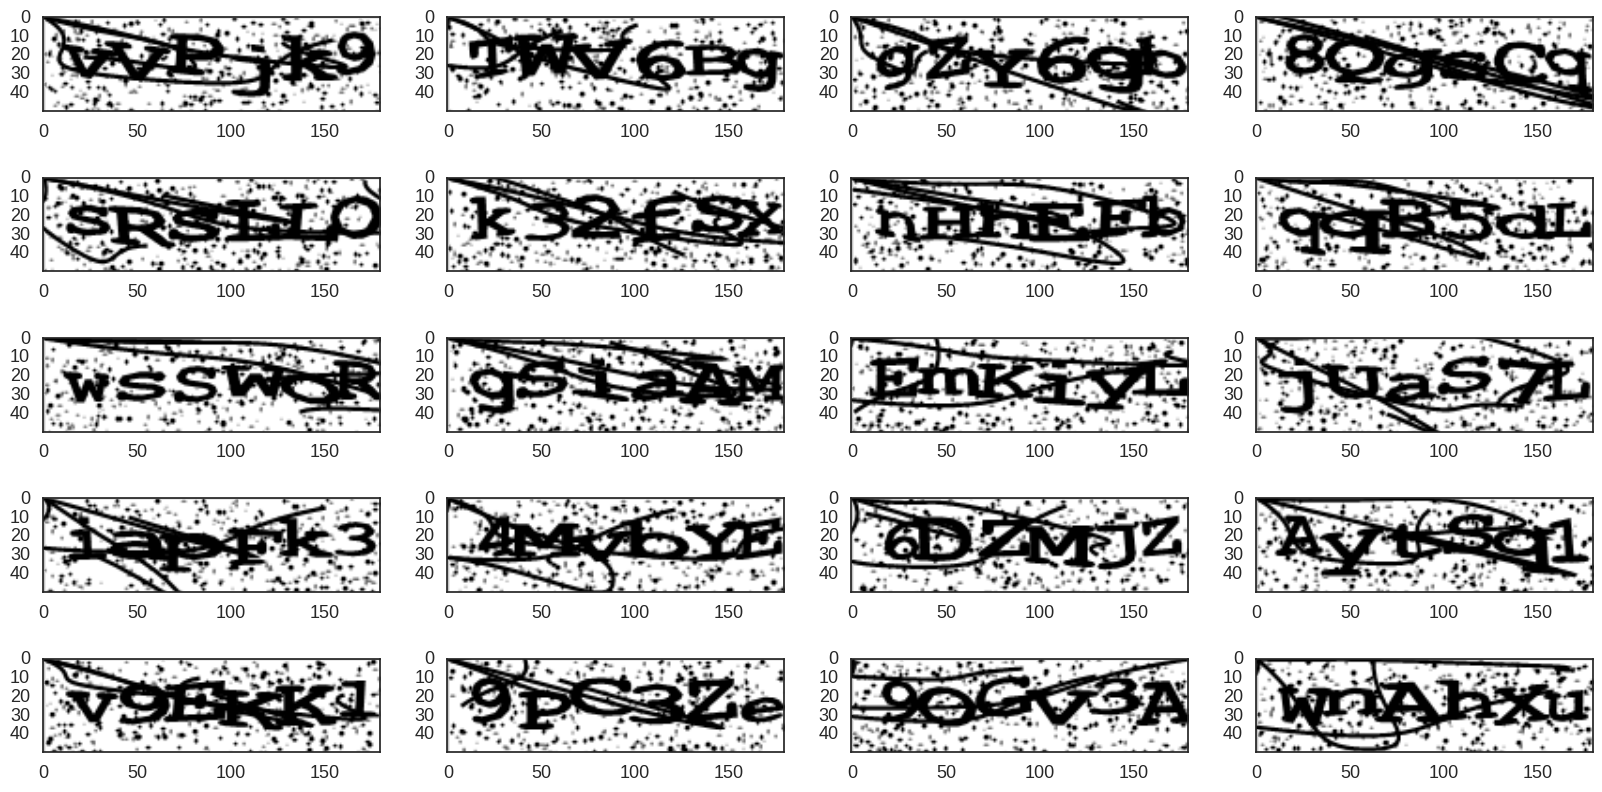

In [5]:
plot_captchas(imgs)

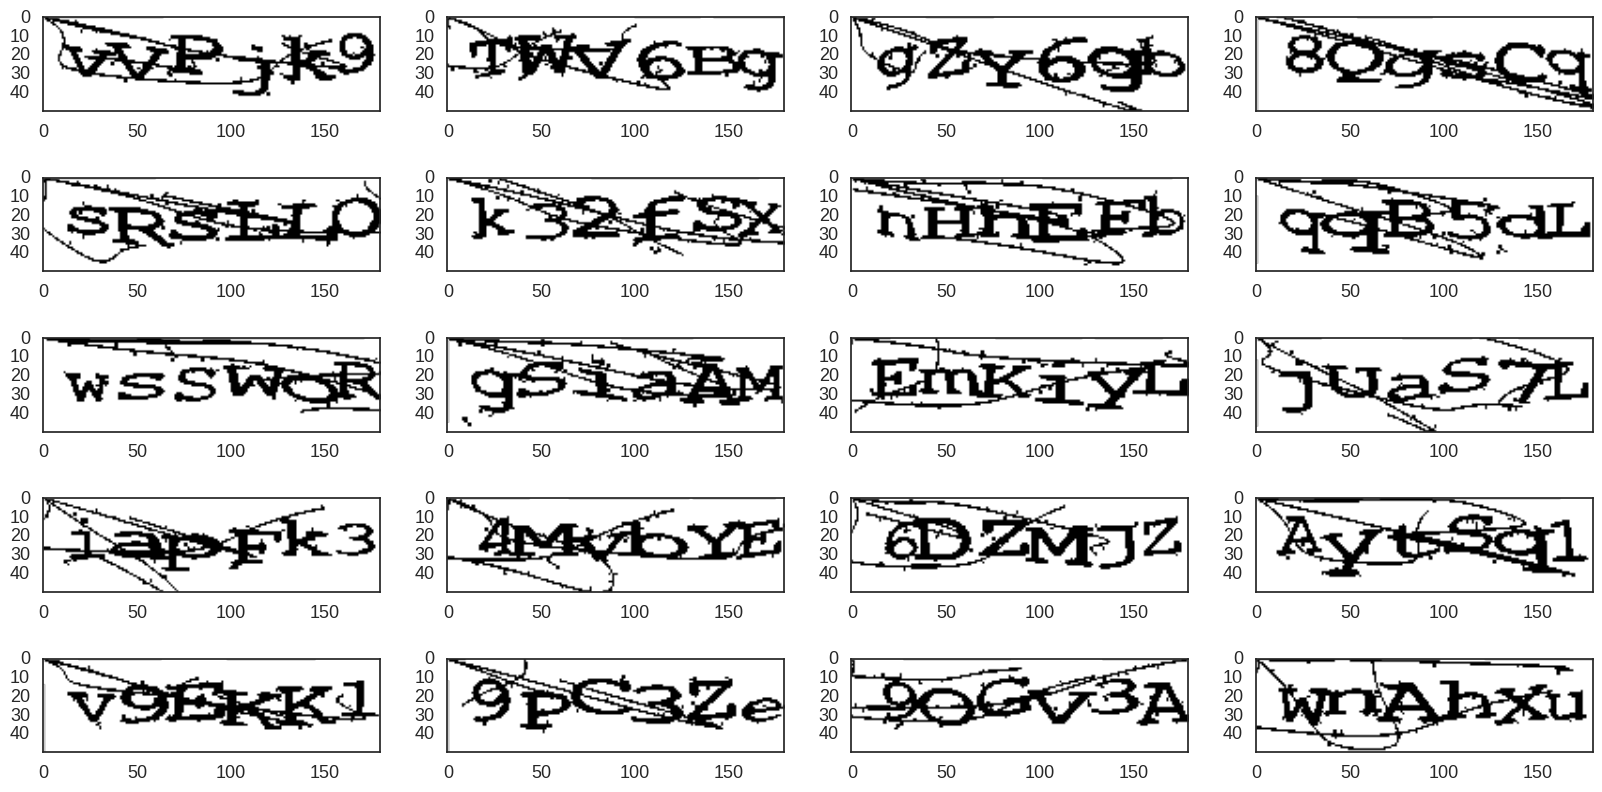

In [6]:
unblobbed = [remove_small_blobs(img, background=255) for img in imgs]
plot_captchas(unblobbed)

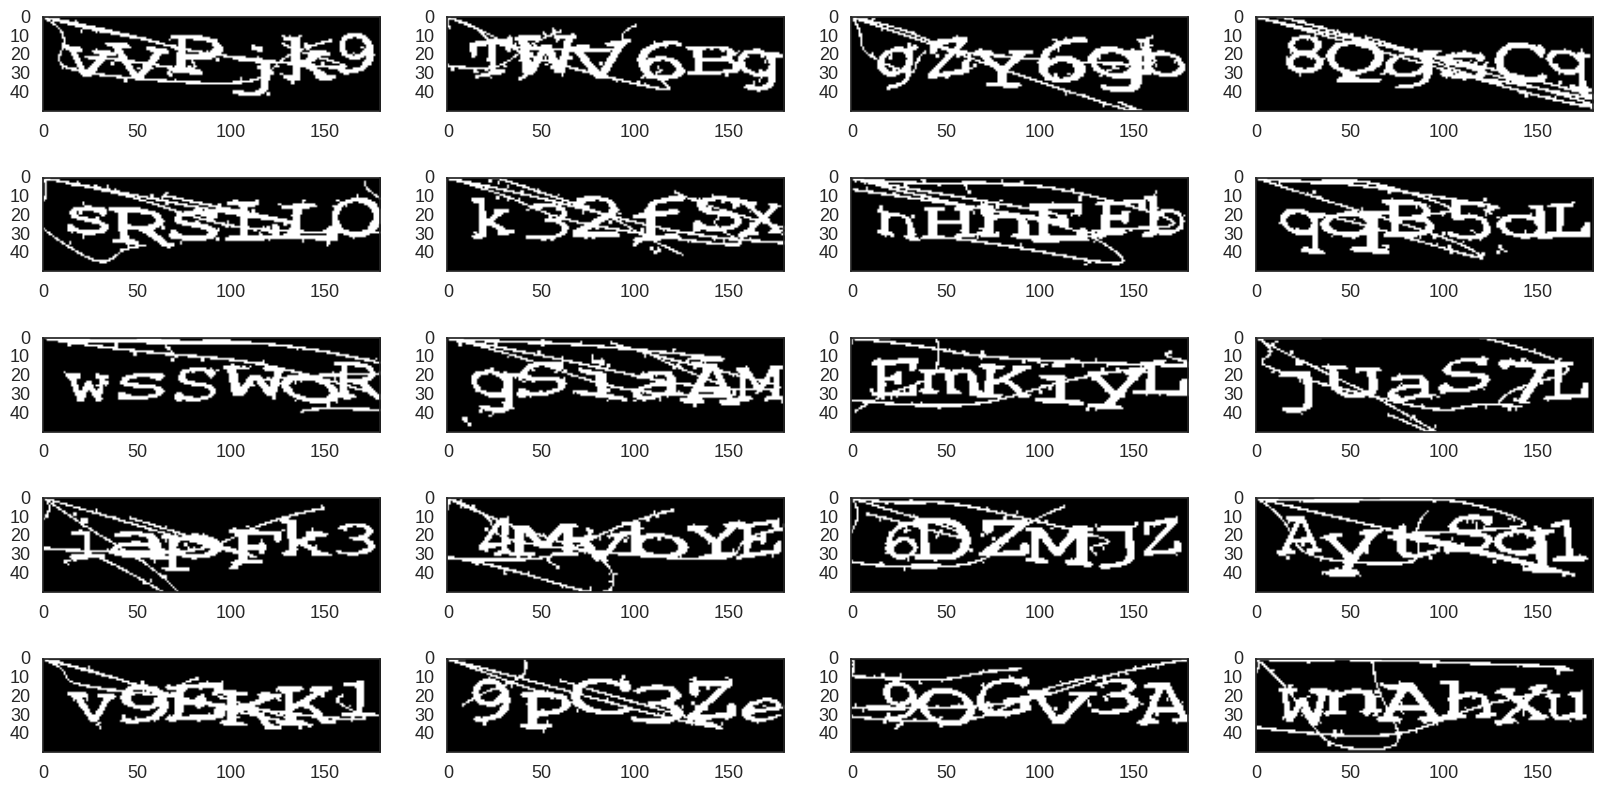

In [10]:
transf = [img[ : , : , 1] for img in unblobbed]
plot_captchas(transf)

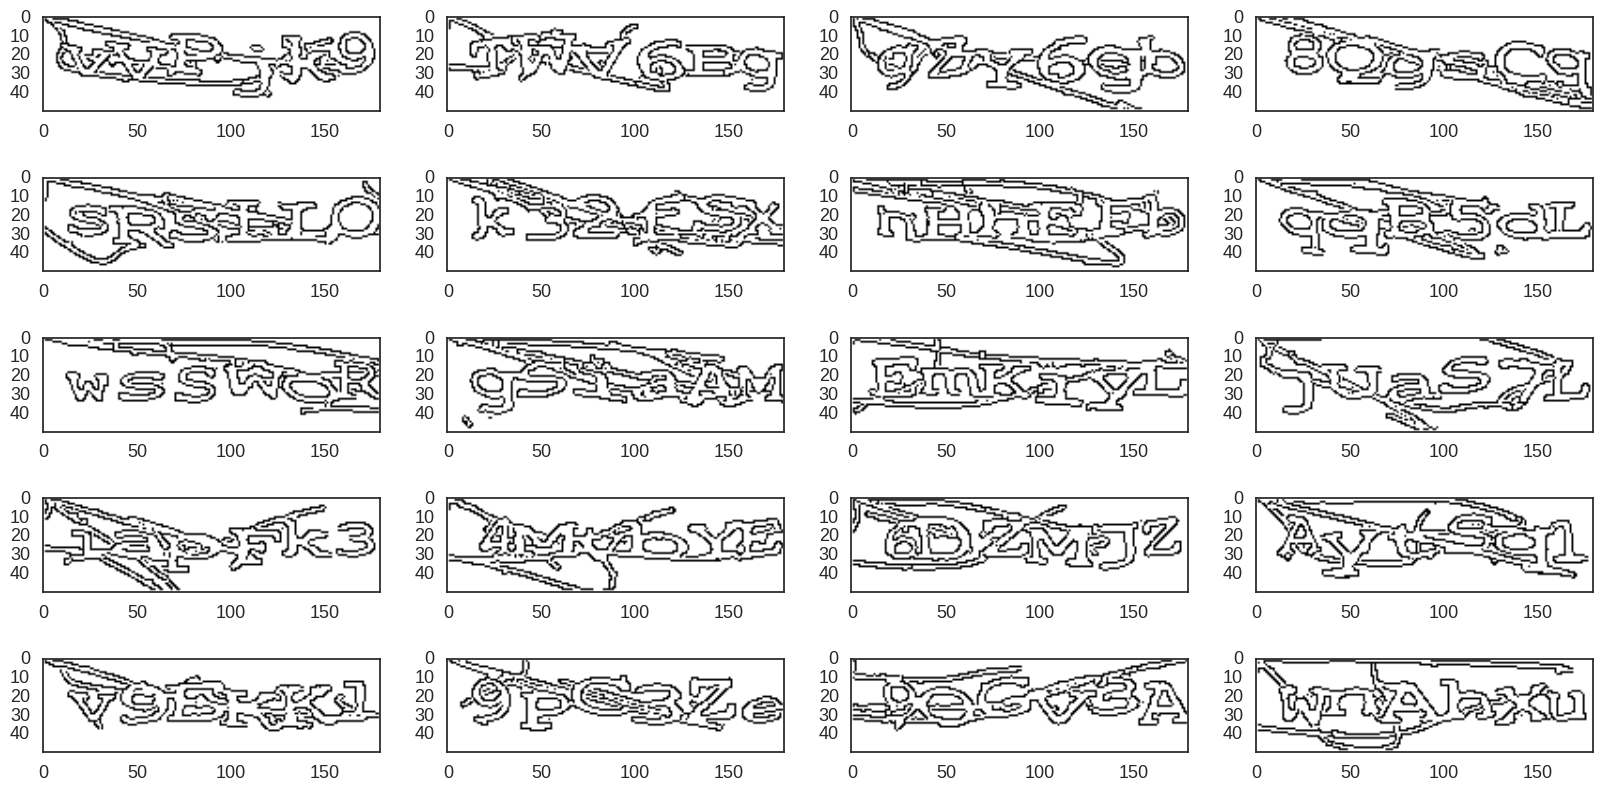

In [11]:
sigma = 1
canny = [feature.canny(img, sigma=sigma) for img in transf]
plot_captchas(canny)

In [ ]:
from skimage.morphology import dilation
from skimage.morphology import disk

selem = disk(1.4)
dilatado = [dilation(img, selem) for img in transf]
plot_captchas(dilatado)

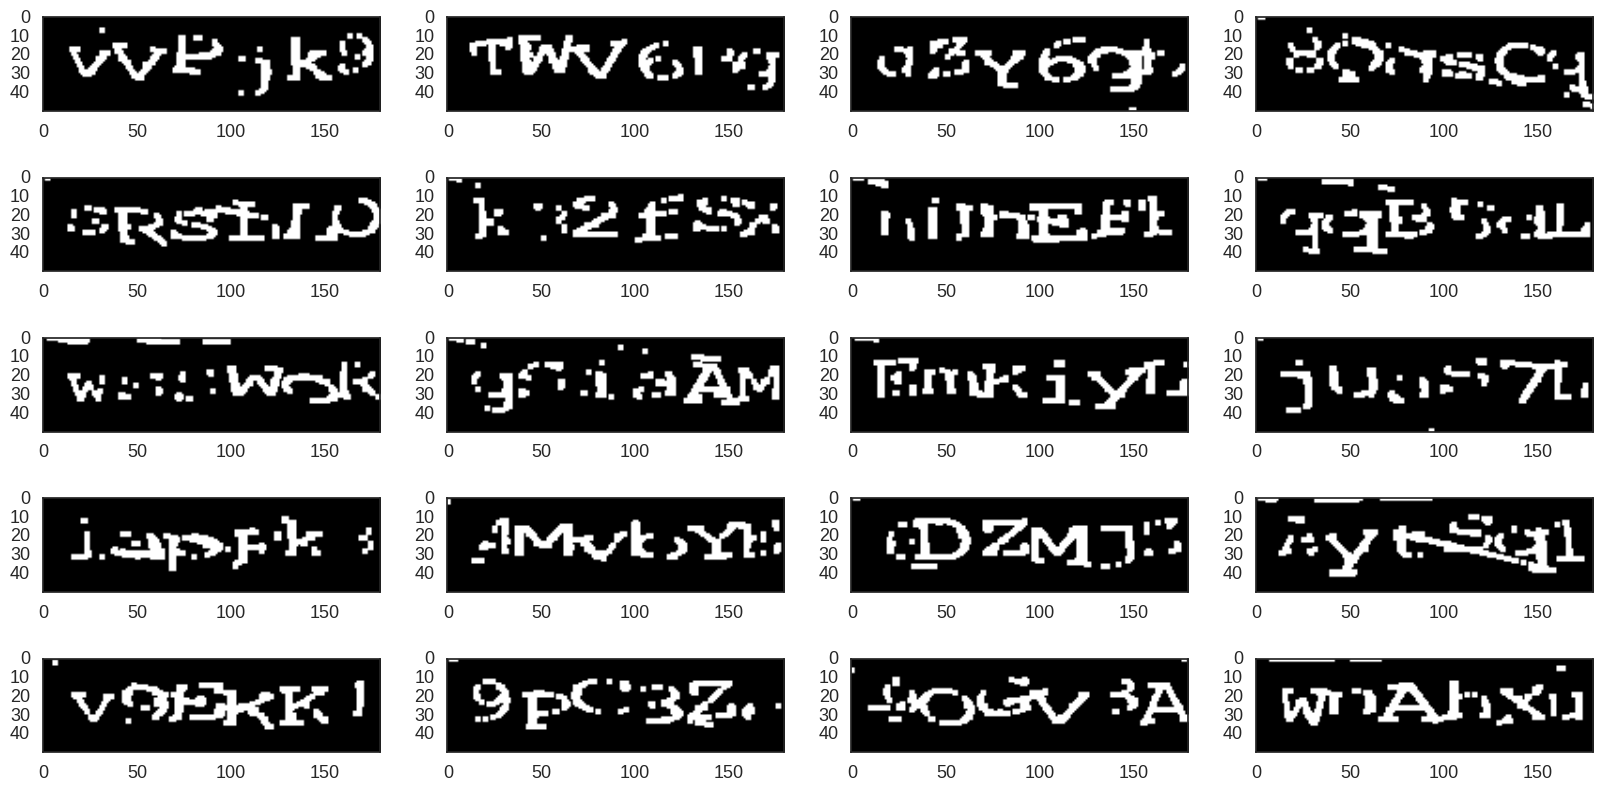

In [31]:
from skimage.morphology import erosion

erode = [erosion(img, selem) for img in dilatado]
plot_captchas(erode)

# Alguns codigos base de filtros

In [12]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

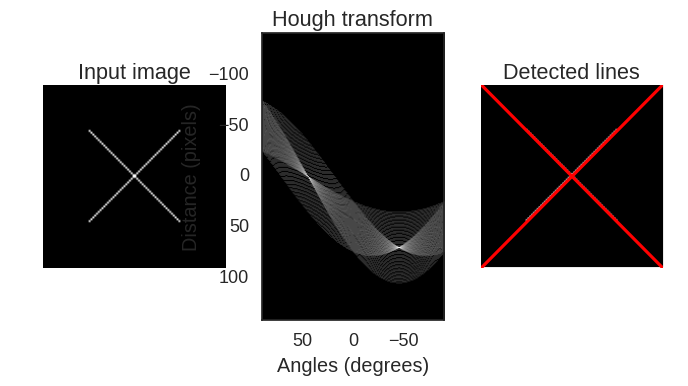

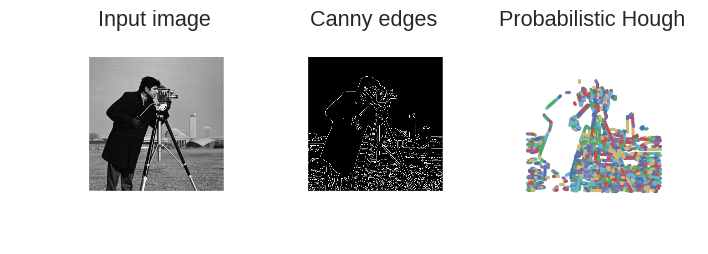

In [13]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()

ax2.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                     d[-1], d[0]],
             cmap=plt.cm.gray, aspect=1/1.5)
ax2.set_title('Hough transform')
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.axis('image')

ax3.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    ax3.plot((0, cols), (y0, y1), '-r')
ax3.axis((0, cols, rows, 0))
ax3.set_title('Detected lines')
ax3.set_axis_off()

# Line finding, using the Probabilistic Hough Transform

image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()
ax1.set_adjustable('box-forced')

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Canny edges')
ax2.set_axis_off()
ax2.set_adjustable('box-forced')

ax3.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    ax3.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax3.set_title('Probabilistic Hough')
ax3.set_axis_off()
ax3.set_adjustable('box-forced')
plt.show()

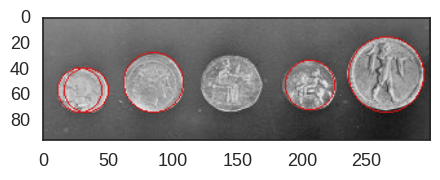

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins()[0:95, 70:370])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 2))

# Detect two radii
hough_radii = np.arange(15, 30, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    num_peaks = 2
    peaks = peak_local_max(h, num_peaks=num_peaks)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)

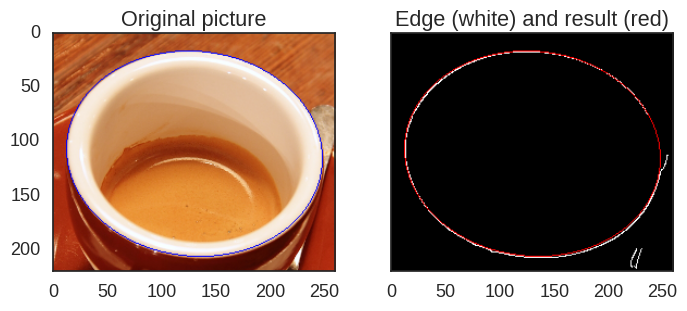

In [15]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(edges)
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()